Prediction a partir des donnees collectes sur OpenStreet Map si nous devons cree une borne dans une grille

Nous observons une certaine relation entre le nombre de stations présentes dans une grille et d'autres variables, telles que le nombre de restaurants, de parkings et d'écoles. Bien que cette corrélation ne prouve pas une relation de causalité directe, nous faisons l'hypothèse que cette causalité est vérifiée et l'exploitons pour modéliser le problème.
Méthodologie de Modélisation et Proposition de Solution

    Analyse des Variables Corrélées
        Utiliser une matrice de corrélation pour identifier et quantifier l'influence de chaque variable sur le nombre de stations présentes dans la grille.
        Attribuer un poids spécifique à chaque variable en fonction de son niveau de corrélation, afin de mesurer son impact relatif.

    Projection du Nombre Futur de Stations Belib en Région Parisienne
        Exploiter les données historiques sur l'évolution du nombre de stations Belib pour établir des projections fiables.
        Prendre en compte les tendances observées et les données socio-économiques pour anticiper le déploiement futur des stations dans la région parisienne.

    Détermination du Nombre de Stations Futures par Grille
        Combiner les poids des variables corrélées avec les projections historiques pour estimer le nombre optimal de stations futures à installer dans chaque grille.
        Identifier les zones où le nombre futures de stations dépasse la capacité actuelle, désignant ainsi ces zones comme zones potentielles pour un déploiement prioritaire.

 L'installation d'une nouvelle station se fera en priorité dans une zone où aucune station n'est actuellement présente. En ce qui concerne les zones disposant déjà d'un grand nombre de stations, il sera essentiel d'évaluer la proximité entre les stations existantes afin d'éviter une saturation. Une analyse supplémentaire de la demande réelle dans ces zones devra également être effectuée, car celle-ci ne peut être entièrement prise en compte par le modèle. Ce modèle servira principalement comme un outil d'aide à la décision, offrant un indice supplémentaire pour orienter les choix stratégiques.


In [45]:
pip install prophet

  Using cached holidays-0.63-py3-none-any.whl.metadata (26 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 12.2 MB/s eta 0:00:0000:010:01
Using cached holidays-0.63-py3-none-any.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import requests
import prophet

In [17]:
df = pd.read_csv('paris_df.csv')


In [18]:
df = df.drop(columns=['Unnamed: 0'])

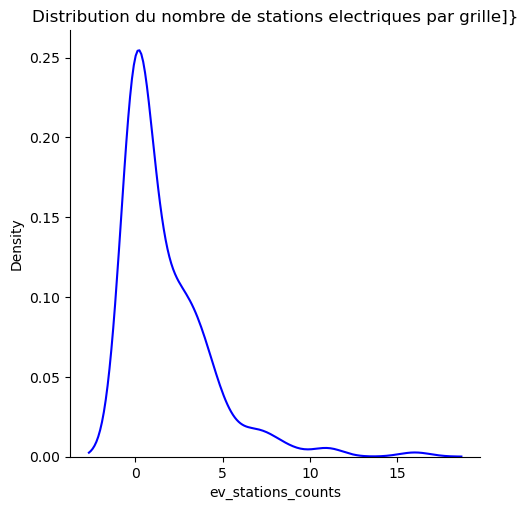

In [19]:
# Create the distribution plot without x-axis values

sns.displot(df['ev_stations_counts'], color='Blue', kind='kde')
plt.title('Distribution du nombre de stations electriques par grille]}')
plt.show()

In [20]:
# Filter for numeric columns
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Calculate summary statistics and transpose
summary_stats = df_numeric.describe().T 

# Sort by standard deviation in descending order
sorted_stats = summary_stats.sort_values(by='std', ascending=False)

# Apply styling: background gradient and bar charts
styled_stats = sorted_stats.style.background_gradient(cmap='GnBu') \
                          .bar(subset=['max'], color='#BB0000') \
                          .bar(subset=['mean'], color='green') 

# Display the styled DataFrame
styled_stats


,count,mean,std,min,25%,50%,75%,max
edges,174.000000,89.735632,68.299994,0.000000,15.500000,100.500000,143.750000,227.000000
restaurant_counts,174.000000,48.936782,65.168714,0.000000,1.000000,25.500000,68.750000,345.000000
nodes,174.000000,53.155172,38.516479,0.000000,10.500000,60.500000,85.750000,130.000000
pop_density,174.000000,39.224063,12.996985,0.000000,30.947661,39.762516,46.848177,66.974038
parking_counts,174.000000,5.850575,9.955425,0.000000,1.000000,3.000000,6.750000,74.000000
school_counts,174.000000,6.660920,6.569765,0.000000,0.000000,6.000000,11.750000,30.000000
retail_counts,174.000000,4.195402,6.500047,0.000000,0.000000,2.000000,5.000000,40.000000
park_counts,174.000000,3.258621,3.764269,0.000000,0.000000,2.000000,5.000000,19.000000
place_of_worship_counts,174.000000,2.212644,2.661144,0.000000,0.000000,1.000000,4.000000,12.000000
ev_stations_counts,174.000000,1.718391,2.495315,0.000000,0.000000,1.000000,3.000000,16.000000


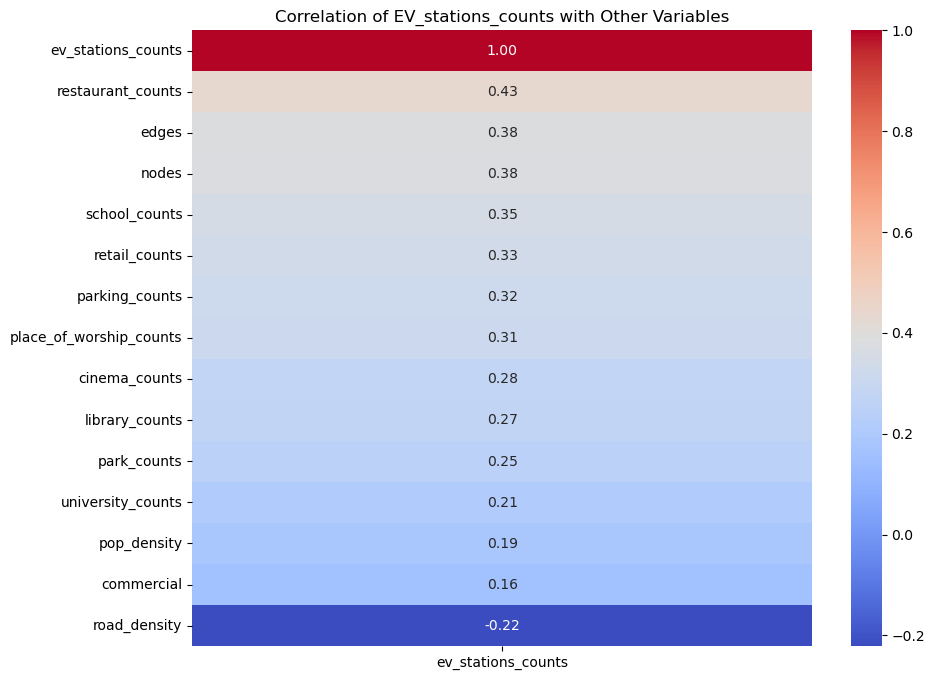

In [21]:


# Calculer la matrice de  correlation matrix avec le nombre de stations par grille
correlation_matrix = df_numeric.corr()['ev_stations_counts'].sort_values(ascending=False)

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', cbar=True, fmt='.2f')
plt.title('Correlation of EV_stations_counts with Other Variables')
plt.show()

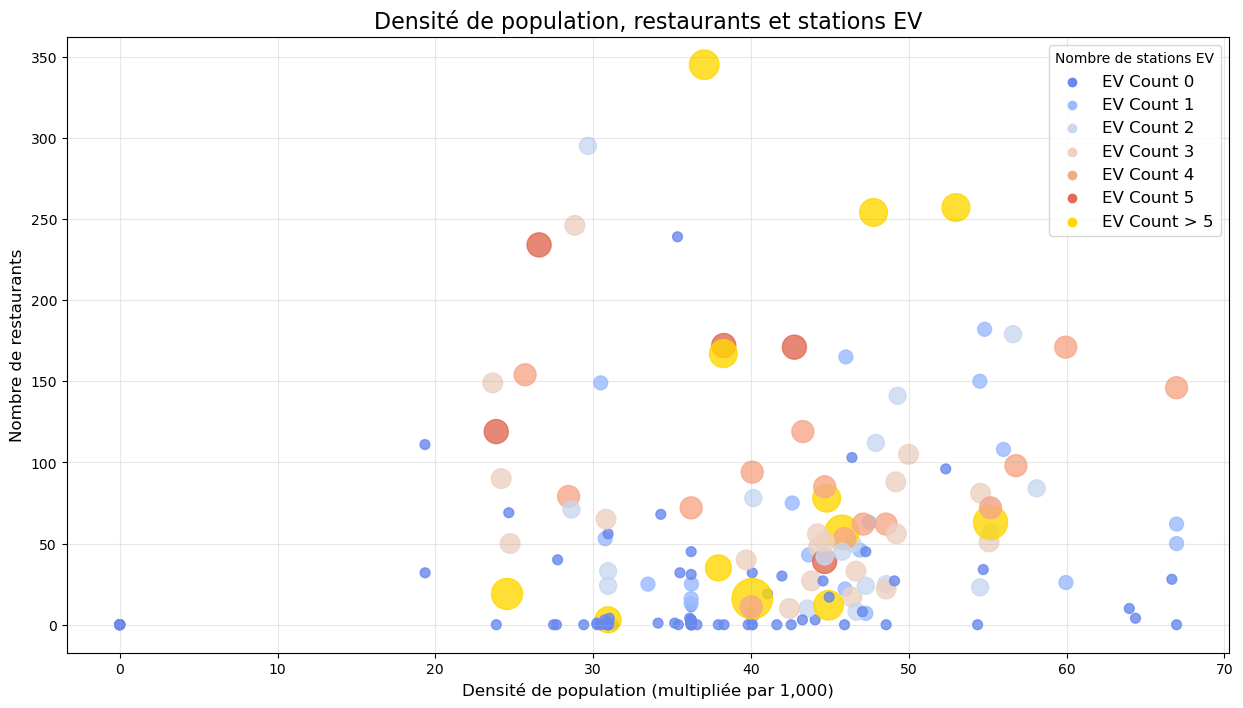

In [38]:
# Définir une palette de couleurs personnalisée et appliquer la correspondance des couleurs
palette_couleurs = sns.color_palette("coolwarm", n_colors=6)
couleurs_ev = df_numeric['ev_stations_counts'].apply(lambda x: palette_couleurs[int(x)] if x <= 5 else 'gold')

# Graphique à bulles
plt.figure(figsize=(15, 8))
plt.scatter(
    df_numeric['pop_density'], 
    df_numeric['restaurant_counts'], 
    s=(df_numeric['ev_stations_counts'] + 1) * 50, 
    alpha=0.8, 
    c=couleurs_ev
)

# Légende et étiquettes
for i in range(6):
    plt.scatter([], [], color=palette_couleurs[i], label=f'EV Count {i}')
plt.scatter([], [], color='gold', label='EV Count > 5')
plt.legend(title='Nombre de stations EV', fontsize=12)

# Titres et étiquettes en français
plt.title('Densité de population, restaurants et stations EV', fontsize=16)
plt.xlabel('Densité de population (multipliée par 1,000)', fontsize=12)
plt.ylabel('Nombre de restaurants', fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [50]:
def get_df_from_url(url):
    # Send a GET request to the API URL
    req = requests.get(url)
    
    # Ensure the request was successful (status code 200)
    if req.status_code == 200:
        wb = req.json()  # Parse the JSON response
        
        # Check if the response is directly a list of records
        if isinstance(wb, list):
            # Directly normalize the list of records into a DataFrame
            df = pd.json_normalize(wb)
        else:
            # If the response contains a 'results' key, normalize that
            df = pd.json_normalize(wb.get("results", []))
        
        return df
    else:
        # Handle failed request (non-200 status code)
        print(f"Failed to retrieve data: {req.status_code}")
        return None

In [51]:
api_url_statique = 'https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/belib-points-de-recharge-pour-vehicules-electriques-donnees-statiques/exports/json'
df_static = get_df_from_url(api_url_statique)

In [53]:
# Construction d'un dataset sur l'évolution du nombre de stations Belib dans le temps

df_static['date_mise_en_service'] = pd.to_datetime(df_static['date_mise_en_service'])
creation_date = df_static[['date_mise_en_service', 'id_station_local']]

# Supprimer les doublons basés sur l'identifiant unique des stations
creation_date = creation_date.drop_duplicates(subset=['id_station_local'])

# Exclure les lignes correspondant à l'année 2024
creation_date = creation_date[creation_date['date_mise_en_service'].apply(lambda x: x.year != 2024)]
creation_date = (creation_date.groupby('date_mise_en_service')
                     .agg({'id_station_local': 'count'})
                     .rename(columns={'id_station_local': 'stations_created'})
                     .sort_index())

creation_date['cumulative_stations'] = creation_date['stations_created'].cumsum()

# Réinitialiser l'index pour faciliter les manipulations futures
creation_date.reset_index(inplace=True)

# Renommer les colonnes
creation_date.rename(columns={'date_mise_en_service': 'ds', 'cumulative_stations': 'y'}, inplace=True)

# Supprimer les fuseaux horaires des dates
creation_date['ds'] = creation_date['ds'].dt.tz_localize(None)


In [55]:
creation_date.head()

,ds,stations_created,y
0,2021-03-15 00:00:00,2,2
1,2021-03-15 14:41:48,1,3
2,2021-03-15 14:41:49,1,4
3,2021-03-15 14:41:50,3,7
4,2021-03-15 14:41:51,2,9


13:15:52 - cmdstanpy - INFO - Chain [1] start processing


13:15:53 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


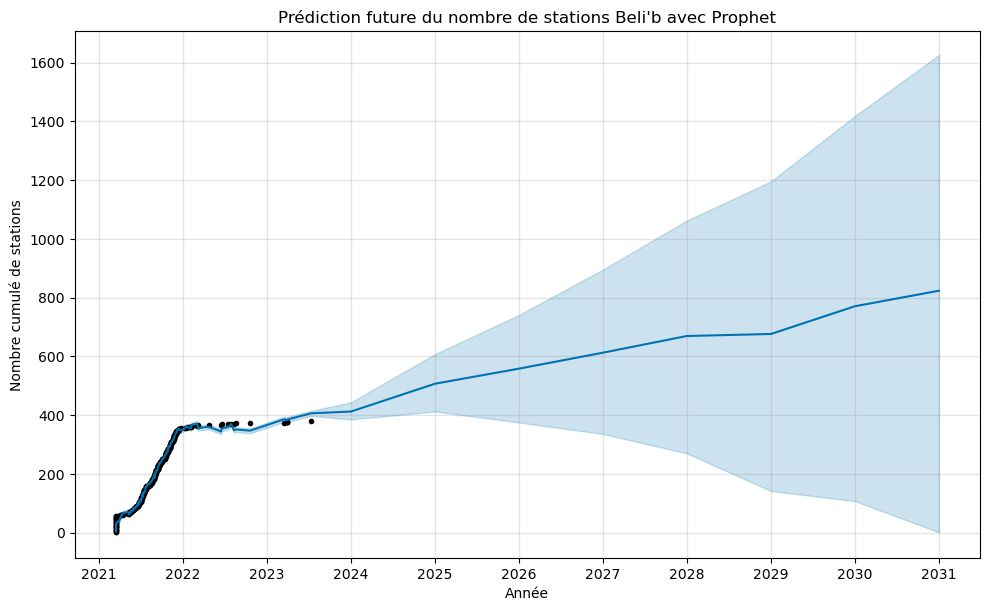

                     ds        yhat  yhat_lower   yhat_upper
347 2023-12-31 13:50:58  411.844498  384.988227   443.385706
348 2024-12-31 13:50:58  506.645979  412.062079   607.503710
349 2025-12-31 13:50:58  557.946161  374.825996   740.809779
350 2026-12-31 13:50:58  612.291041  335.622301   895.245324
351 2027-12-31 13:50:58  669.058738  269.594847  1062.189995
352 2028-12-31 13:50:58  676.022576  141.377199  1195.473065
353 2029-12-31 13:50:58  770.425750  107.053220  1418.044657
354 2030-12-31 13:50:58  823.101869    1.002889  1625.909376


In [61]:
# 2. Création et ajustement du modèle Prophet
# Initialiser le modèle Prophet
model = Prophet()  
# Ajuster (entraîner) le modèle sur les données historiques
model.fit(creation_date)

# 3. Génération des dates futures
# Générer un DataFrame contenant 8 années futures à partir des données historiques
future = model.make_future_dataframe(periods=8, freq='Y')  
# Prédire les valeurs pour les dates futures générées
forecast = model.predict(future)

# 4. Visualisation des prédictions
# Tracer les prédictions générées par le modèle Prophet
model.plot(forecast)
plt.title("Prédiction future du nombre de stations Beli'b avec Prophet")  # Ajouter un titre au graphique
plt.xlabel("Année")  # Étiqueter l'axe des x
plt.ylabel("Nombre cumulé de stations")  # Étiqueter l'axe des y
plt.show()

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(8))